# Técnica de Classificação - Grid Search

#### **Contextualização**

Neste projeto, simulamos um desafio enfrentado por engenheiros da indústria ProQuim, que buscam identificar possíveis anomalias operacionais em um compressor instalado na área 100 da planta industrial.

Ao longo de um ano, foram coletados dados operacionais dos compressores, como:

* Temperatura

* Pressão

* Velocidade

* Vibração

Além disso, foi registrada a condição de operação de cada equipamento, classificando-os como em condição normal ou condição anômala.

O objetivo do projeto é desenvolver um modelo de Machine Learning do tipo Máquina de Vetores de Suporte (SVM), capaz de classificar corretamente o estado operacional do compressor. Para isso, serão ajustados os hiperparâmetros C e gamma por meio de uma busca em grade (Grid Search), utilizando a estratégia de validação cruzada k-fold.

Após a seleção dos melhores hiperparâmetros, o modelo final será avaliado com a técnica holdout, a fim de estimar sua capacidade de generalização em dados não vistos.

Os dados utilizados estão disponíveis no arquivo df_compressor.csv.

## Importação das bibliotecas

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

## Carregamento e Análises Iniciais

In [17]:
df = pd.read_csv('df_compressor.csv', index_col=0)

In [18]:
df.head()

,Temperatura,Pressao,Velocidade,Vibracao,Anomalia
0,45.599707,18.513293,130.852842,6.727030,0.0
1,77.289287,54.190095,123.489400,7.966814,0.0
2,65.259667,87.294584,453.127290,2.504679,0.0
3,57.926217,73.222489,124.773100,6.248741,0.0
4,33.581025,80.656115,135.974863,5.717460,0.0


In [19]:
df.shape

(1000, 5)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperatura  1000 non-null   float64
 1   Pressao      1000 non-null   float64
 2   Velocidade   1000 non-null   float64
 3   Vibracao     1000 non-null   float64
 4   Anomalia     1000 non-null   float64
dtypes: float64(5)
memory usage: 46.9 KB


In [21]:
df.duplicated().value_counts()

False    1000
Name: count, dtype: int64

In [22]:
df.describe()

,Temperatura,Pressao,Velocidade,Vibracao,Anomalia
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000
mean,51.964110,50.701731,251.202863,4.903750,0.2000
std,16.067555,29.218989,145.337098,2.864893,0.4002
min,25.254761,0.321826,0.005817,0.006534,0.0000
25%,37.978530,24.107427,130.675489,2.419008,0.0000
50%,52.324406,51.873391,250.306960,4.842793,0.0000
75%,65.937577,76.046506,379.551764,7.375408,0.0000
max,79.984472,99.941373,498.910428,9.995577,1.0000


In [23]:
print('0 (ausência de anomalia) | número de amostras = {}'.format(df['Anomalia'].value_counts()[0]))
print('1 (presença de anomalia) | número de amostras = {}'.format(df['Anomalia'].value_counts()[1]))

0 (ausência de anomalia) | número de amostras = 800
1 (presença de anomalia) | número de amostras = 200


In [24]:
ausen_ano_pro = (df['Anomalia'].value_counts()[0]) / len(df['Anomalia'])
prese_ano_pro = (df['Anomalia'].value_counts()[1]) / len(df['Anomalia'])


print(f'Ausência de anomalia representa {ausen_ano_pro*100}% frente à presença de anomalia com {prese_ano_pro*100}%')

Ausência de anomalia representa 80.0% frente à presença de anomalia com 20.0%


Observa-se que o banco de dados está desbalanceado, com uma proporção de 80% de registros sem anomalias, enquanto apenas 20% apresentam anomalias.

## Separação das variáveis de entrada (X) e saída (y)

In [25]:
X = df.drop(['Anomalia'], axis=1)
y = df[['Anomalia']]

## Divisão do banco de dados

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=50, stratify=y)

In [27]:
X_train.describe()

,Temperatura,Pressao,Velocidade,Vibracao
count,800.000000,800.000000,800.000000,800.000000
mean,52.577306,50.893160,250.589611,4.841685
std,16.032600,29.167993,146.345883,2.892094
min,25.278387,0.321826,0.005817,0.006534
25%,38.739245,24.183413,130.047294,2.334861
50%,53.107467,53.162996,249.824203,4.700337
75%,66.586868,76.102497,379.900339,7.387590
max,79.984472,99.941373,498.910428,9.995577


In [28]:
y_train.describe()

,Anomalia
count,800.00000
mean,0.20000
std,0.40025
min,0.00000
25%,0.00000
50%,0.00000
75%,0.00000
max,1.00000


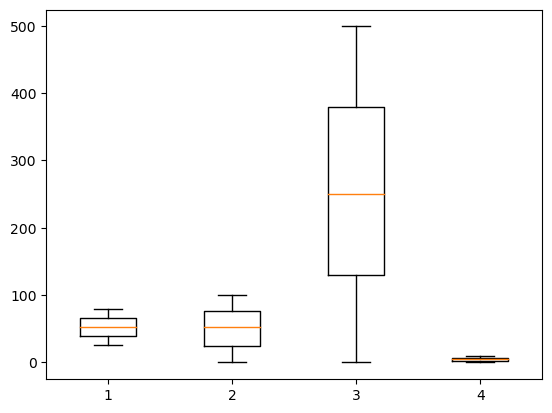

In [29]:
plt.boxplot(X_train)
plt.show()

Se faz necessário normalizar os dados de entrada. Para os dados de saída, como se diversificam entre 0 e 1, não será necessária a normalização.

## Normalização dos dados

In [30]:
scaler_input = MinMaxScaler(feature_range=(-1,1))
scaler_input.fit(X_train)

X_train_norm = scaler_input.transform(X_train)
X_test_norm = scaler_input.transform(X_test)

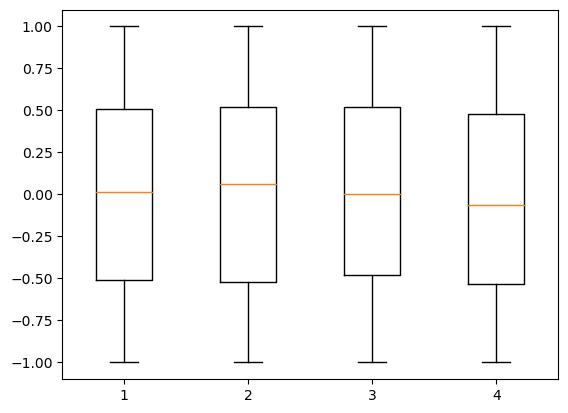

In [31]:
plt.boxplot(X_train_norm)
plt.show()

##### 4 - Sintonia dos hiperparâmetros do modelo de predição

* A [máquina de vetores de suporte](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) será o modelo de predição utilizado neste exemplo.
* Serão sintonizados os seguintes hiperparâmetros desse tipo de modelo de predição: **C** e **gamma**.
* A sintonia dos hiperparâmetros será realizada via busca em grade (*grid search*). A sintonia dos hiperparâmetros requer a utilização de técnicas de estimação de performance. Neste exemplo, será utilizada a técnica ***k-fold cross validation*** durante a execução da sintonia dos hiperparâmetros.

4.1 - Busca em grade (*grid search*) com técnica *k-fold cross validation*

* O comando computacional [```GridSearchCV()``` da biblioteca *scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) será utilizado para viabilizar implementar a busca em grade (*grid search*) com validação cruzada (*cross validation*) em linguagem de programação *Python*.

* Para utilizar o comando computacional ```GridSearchCV()``` na tarefa de classificação em evidência neste exemplo, faz-se necessário definir os seguintes parâmetros: o tipo de modelo de classificação (```estimator```); os valores dos hiperparâmetros do modelo de predição que devem compor a grade de busca (```param_grid```); os dados de saída (```y```); a métrica de desempenho (```scoring```); e o número de partições *k* (```cv```). A seguir encontra-se evidenciado como esses parâmetros são definidos no ```GridSearchCV()```:

```python
            GridSearchCV(estimator,
                         param_grid,                                         
                         scoring=None,
                         cv=None)

```

* Resalta-se que não é necessário inserir nenhum parâmetro adicional para estratificar as classes durante a execução do comando [```GridSearchCV()``` da biblioteca *scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para a tarefa de classificação ora discutida.

In [32]:
# Definir os valores de hiperparâmetros atrelados à busca em grade
C = [0.001,0.01,0.1,1,10,100,1000]
gamma = [0.001,0.01,0.1,1,10,100,1000]

parameters = {'C':C, 'gamma':gamma}

# Dataframe para armazenamento dos valores
scores_df = pd.DataFrame(index=gamma, columns=C)

In [33]:
# Instanciar o modelo de predição
model = SVC(random_state=50)

# Executar a busca em grade em conjunto com a técnica k-fold cross validation
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=10)
grid_search.fit(X_train_norm, y_train.values.ravel())

GridSearchCV(cv=10, estimator=SVC(random_state=50),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy')

In [34]:
# Acessar os hiperparâmetros mais adequados segundo o valor médio da métrica de desempenho
grid_search.best_params_

{'C': 10, 'gamma': 1}

In [35]:
# Acessar o valor médio da métrica de desempenho atrelado aos hiperparâmetros mais adequados
grid_search.best_score_

0.8012500000000001

In [36]:
# Salvar em um dataframe
info_grid_search = pd.DataFrame.from_dict(grid_search.cv_results_)

In [37]:
info_grid_search

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011365,0.001343,0.003997,0.000629,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
1,0.010294,0.000437,0.003231,0.000590,0.001,0.010,"{'C': 0.001, 'gamma': 0.01}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
2,0.010588,0.002145,0.003821,0.001053,0.001,0.100,"{'C': 0.001, 'gamma': 0.1}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
3,0.011267,0.002182,0.003429,0.000905,0.001,1.000,"{'C': 0.001, 'gamma': 1}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
4,0.010268,0.000510,0.003252,0.000388,0.001,10.000,"{'C': 0.001, 'gamma': 10}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
5,0.011477,0.001930,0.003802,0.000975,0.001,100.000,"{'C': 0.001, 'gamma': 100}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
6,0.023604,0.001599,0.005986,0.000998,0.001,1000.000,"{'C': 0.001, 'gamma': 1000}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
7,0.011574,0.000494,0.004082,0.000540,0.010,0.001,"{'C': 0.01, 'gamma': 0.001}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
8,0.015045,0.002505,0.005226,0.001531,0.010,0.010,"{'C': 0.01, 'gamma': 0.01}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2
9,0.012147,0.001694,0.003722,0.000486,0.010,0.100,"{'C': 0.01, 'gamma': 0.1}",0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.8000,0.80000,0.000000,2


In [38]:
# Criar um dataframe a fim de criar um mapa de calor
scores_df = pd.DataFrame()
scores_df['C'] = pd.to_numeric(info_grid_search['param_C'].values)
scores_df['gamma'] = pd.to_numeric(info_grid_search['param_gamma'].values)
scores_df['mean_test_score'] = pd.to_numeric(info_grid_search['mean_test_score'].values)
scores_df = scores_df.pivot(index='gamma', columns='C', values='mean_test_score')

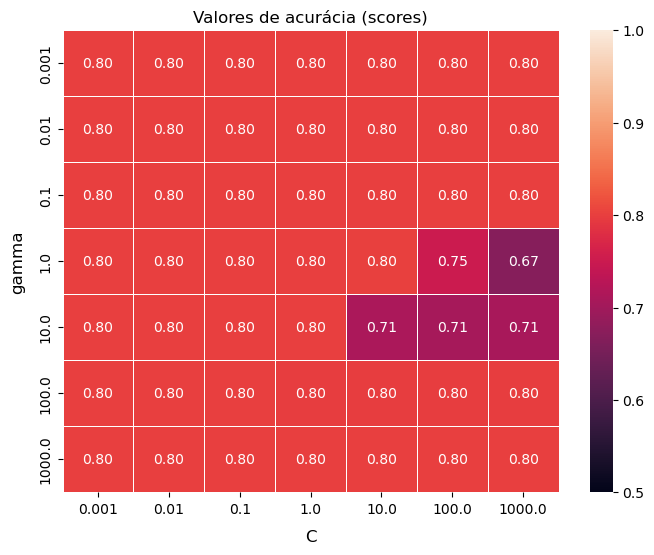

In [39]:
# Heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(scores_df, annot=True, fmt=".2f", linewidths=0.6, vmin=0.5, vmax=1.0, cbar=True)
ax.set_title('Valores de acurácia (scores)', fontsize=12)
ax.set_ylabel(ylabel='gamma', fontsize=12, labelpad=10)
ax.set_xlabel(xlabel='C', fontsize=12, labelpad=10)
plt.show()

4.1.1.2 - Análise exploratória | **métrica *F1 score***

In [40]:
# Definir os valores de hiperparâmetros atrelados à busca em grade
C = [0.001,0.01,0.1,1,10,100,1000]
gamma = [0.001,0.01,0.1,1,10,100,1000]

parameters = {'C':C, 'gamma':gamma}

# Dataframe para armazenamento dos valores
scores_df = pd.DataFrame(index=gamma, columns=C)

In [41]:
# Instanciar o modelo de predição
model = SVC(random_state=50)

# Executar a busca em grade em conjunto com a técnica k-fold cross validation
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=10)
grid_search.fit(X_train_norm, y_train.values.ravel())

GridSearchCV(cv=10, estimator=SVC(random_state=50),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='f1')

In [42]:
# Acessar os hiperparâmetros mais adequados segundo o valor médio da métrica de desempenho
grid_search.best_params_

{'C': 1000, 'gamma': 10}

In [43]:
# Acessar o valor médio da métrica de desempenho atrelado aos hiperparâmetros mais adequados
grid_search.best_score_

0.1915684778184778

In [44]:
# Salvar em um dataframe
info_grid_search = pd.DataFrame.from_dict(grid_search.cv_results_)

In [45]:
# Criar um dataframe a fim de criar um mapa de calor
scores_df = pd.DataFrame()
scores_df['C'] = pd.to_numeric(info_grid_search['param_C'].values)
scores_df['gamma'] = pd.to_numeric(info_grid_search['param_gamma'].values)
scores_df['mean_test_score'] = pd.to_numeric(info_grid_search['mean_test_score'].values)
scores_df = scores_df.pivot(index='gamma', columns='C', values='mean_test_score')

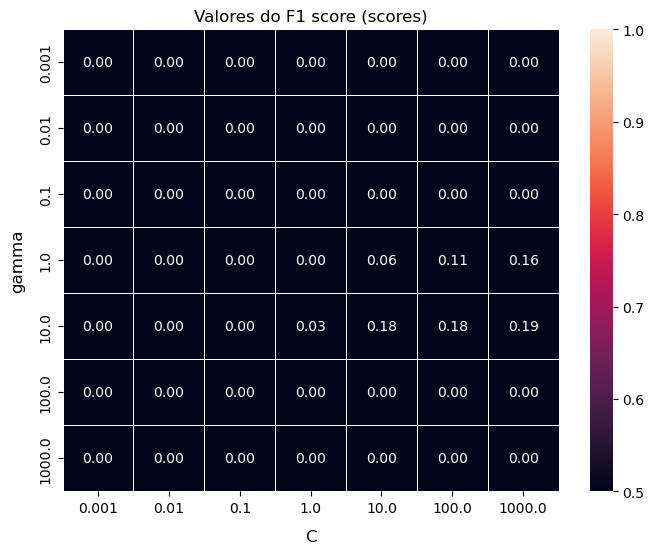

In [46]:
# Heatmap
plt.figure(figsize=(8,6))
ax = sns.heatmap(scores_df, annot=True, fmt=".2f", linewidths=0.6, vmin=0.5, vmax=1.0, cbar=True)
ax.set_title('Valores do F1 score (scores)', fontsize=12)
ax.set_ylabel(ylabel='gamma', fontsize=12, labelpad=10)
ax.set_xlabel(xlabel='C', fontsize=12, labelpad=10)
plt.show()

##### 5 - Treinamento do modelo com os hiperparâmetros sintonizados via busca em grade (*grid search*)

In [47]:
# Definir os valores para C e gamma:
C = 1000
gamma = 10

# Instanciar o tipo de modelo de predição - máquina de vetores de suporte para classificação:
model = SVC(C=C, gamma=gamma, random_state=50)

# Treinar o modelo:
model.fit(X_train_norm, y_train.values.ravel())

SVC(C=1000, gamma=10, random_state=50)

##### 6 - Avaliação da capacidade de generalização do modelo de predição

In [48]:
# Estimar a capacidade de generalização do modelo de predição:
y_pred_test = model.predict(X_test_norm)

# Inserir a métrica de desempenho adequada
f1 = f1_score(y_test, y_pred_test)

print("CAPACIDADE DE GENERALIZAÇÃO DO MODELO\nValor da métrica de desempenho = {}".format(f1))

CAPACIDADE DE GENERALIZAÇÃO DO MODELO
Valor da métrica de desempenho = 0.08571428571428572
